# STAT301 Final Project - Group 20

## Introduction
Our global economy drives and depends on functioning companies all around the world, and the characteristics that all organizations have in common are their need and value of their workforce. Employees are one of the most valuable assets and retaining quantity and quality of employees are crucial in running a dependable organization (Negi et. Al, 2013). The failure to do so is called employee attrition, which is a costly challenge faced by many employers around the world. The latter however, is inevitable and managing it is a challenge. Understanding reasons or predictors that could explain employee attrition would provide managers with areas to focus and improve on in the future to improve employee retention (Frye et. Al, 2018). 

## Dataset Description
The dataset chosen: HR Analytics (Konapure & Uikey, 2023) containing 35 different employee factors and characteristics that can be analyzed to understand and interpret organizational data, detecting possible trends and patterns which can be generalized and implemented by companies to assist attrition management. 

**Brief Summary of Entire Dataset**

|Continuous Data|Nominal Data|Ordinal Data|Binary Data|  
|----------------|------------|------------|---------|
|Age           | Employee ID | Frequency of Business Travel | Employee Attrition|
|Daily Wage | Department | Education Level | Over 18|
|Distance to Office | Field of Qualification | Enviromental Satsifcation | Worked Overtime|
|Hourly Rate | Gender | Job Involvement |
|Monthly Income | Marital Status | Job Level |
|Monthly Rate | Job Role | Job Satisfaction 
|Number of Companies Worked | | Performance Rating 
|Percentage Salary Hike | | Relationship Satisfaction 
|Standard Hours | | Stock Option Level 
|Total Working Years| | Work Life Balance
|Training Time |
|Years at Company |
|Years in Current Role |
|Years Since Last Position 
|Years with Current Manager

## Research Question
In our report, we aim to answer the question: **“How can we predict when employees are going to leave?”**

“How can we predict when employees are going to leave? (attrition = 1)” (N)
* Modifying logistic regression to prefer attrition = 1, mention how there’s an imbalance in the response classes
* Discuss how employees departing the company will be a minority (often) of individuals, however we need to design a model using all employee data that can be used to predict the small number of employees that are leaving

“How can we understand what variables are contributing to employee attrition?”
* Using post-lasso to be able to conduct inference
* Idea: splitting data into 3; training-postlasso-test


# Exploratory Data Analysis
To conduct our analysis, we will need to: load the dataset, clean it, and convert it to a tidy format. Below, we load our dataset from the *HR-Employee-Attrition.csv*, convert character columns to factors, and perform a simple check for NA values. Luckily our dataset is already relatively clean from empty values. However, from the dataset description we know that a number of the numeric columns such as `Education` and `JobLevel` represent categorial data. To address this, we will convert all numeric columns with less than 5 distinct values to factors. Finally, we remove superfluous columns such as `Over18`, `EmployeeCount`, `EmployeeNumber`, and `StandardHours` which will not help us predict MonthlyIncome.

In [1]:
suppressMessages(suppressWarnings({
  library(ggplot2)
  library(knitr)
  library(tidyverse)
  library(gridExtra)
  library(kableExtra)
  library(glmnet)
  library(dplyr)
}))

In [2]:
# Main developer: Bill
# Contributor: Caden

# Load the data and check for NA values
hr_data <- read.csv("HR-Employee-Attrition.csv", stringsAsFactors = TRUE)
print(paste("Number of NA values:", sum(is.na(hr_data))))

# Convert numeric categorial columns to factors
hr_data <- hr_data |> 
    mutate_if(function(col) {
        is.numeric(col) & n_distinct(col) <= 5 
    }, as.factor)

# Remove unnecessary columns
hr_data <- hr_data |> 
    select(-Over18, -EmployeeCount, -EmployeeNumber, -StandardHours)

# Extract response vector and data matrix
y <- hr_data$Attrition
X <- hr_data |> select(-Attrition)

# Display data preview
head(hr_data)

[1] "Number of NA values: 0"


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


# Section 2b (I think)

Now we define a new function for assessing the performance of a logistic regression model. Given a Confusion Matrix `conf_in`, it extracts the number of True Positives (`TP`), False Positives (`FP`), True Negatives (`TN`) and False Negatives (`NP`). From these values, we compute Accuracy, Precision, Sensitivity and Specificity and return it as a `list`. 

In [3]:
# Main developer: Caden

# compute the performance metrics given a conf. matrix
compute_metrics <- function(conf_in){
  # extract table info
  TP <- conf_in[2, 2]
  FP <- conf_in[2, 1]
  TN <- conf_in[1, 1]
  FN <- conf_in[1, 2]
  # compute metrics
  accuracy <- (TP + TN) / sum(conf_in)
  precision <- TP / (TP + FP)
  sensitivity <- TP / (TP + FN)
  specificity <- TN / (TN + FP)
  # return everything
  return(list(
    ACC = accuracy,
    PRE = precision,
    SEN = sensitivity,
    SPC = specificity
  ))
}

Now, we fix the seed and designate a training set (containing $60\%$ of observations) and an inference set (containing $40\%$ of observations.) We also define the `model.matrix` to get our covariates ready for input into `glmnet`. 

In [4]:
# Main developer: Caden
# Contributor: Bill

set.seed(42)
# rename to match my conventions
df <- hr_data
# train-test split: 60-40
train_indices <- sample(1:nrow(df), size = 0.50 * nrow(df), replace = FALSE)
# get unselected indices
unselected <- setdiff(1:nrow(df), train_indices)
small_indices <- sample(unselected, size = 0.50 * length(train_indices), replace = FALSE)
# testing performance
train <- df[train_indices, ]
inference  <- df[small_indices, ]
test  <- df[setdiff(unselected, small_indices), ]
# prepare data for glmnet
x <- model.matrix(Attrition ~ . - 1, data = train)
y <- as.numeric(train$Attrition == "Yes")
# write train and inference response as boolean
train$Attrition <- as.numeric(train$Attrition == "Yes")
inference$Attrition <- as.numeric(inference$Attrition == "Yes")

Then, for weights $w \in [1,10]$ we apply a weight of $w$ to the set of $\{y \in \mathbf{\vec{y}} \mid y = 1\}$ to follow the procedure described in the Methods section. Then, for each weight, we construct a model $\mathcal{M}_w$ by selecting the variables using Lasso Constraints and cross-validation. Then, we compute and record the in-sample metrics and store the model information in the `models_list`. 

In [5]:
# Main developer: Caden
# Approximate Runtime: 30 Seconds

set.seed(42)
# define weights and lists
weights_list <- 1:10
models_list <- list()
results_rw <- list()
perf_list <- list()
# iterate across weights results
for(w in weights_list){
  
  # increase weight of employee leaving by `w`
  weights <- ifelse(y == 1, w, 1)
  
  # ----------------------- #
  # --- Logistic LASSO ---- #
  # ----------------------- #
  # CV Lasso Logistic
  cv_logistic <- cv.glmnet(
    x, y,
    # using LASSO 
    alpha = 1,
    # weights in this iteration
    weights = weights,
    # logistic regression
    family = "binomial",
    # 15-fold CV
    nfolds = 15
  )
  # in-sample predictions
  yhat_lasso <- as.numeric(predict(
    cv_logistic,
    newx = x,
    s = "lambda.min",
    type = "response"
  ) > 0.5)
  # compute confusion matrix metrics
  mat_ins_w <- compute_metrics(table(yhat_lasso, y))
  
  # ----------------------- #
  # --- Selected Vars. ---- #
  # ----------------------- #
  # then extract chosen variables
  coefs_min <- coef(cv_logistic, s = "lambda.min")
  s_min <- rownames(coefs_min)[which(coefs_min != 0)]
  s_min <- s_min[s_min != "(Intercept)"]
  # match training columns to the original columns
  matched_columns <- unique(sapply(s_min, function(var) {
    # match selected columns+factor levels to
    matches <- colnames(df)[which(sapply(colnames(df), function(orig)
      grepl(orig, var)))]
    if (length(matches) > 0) {
      # get longest match name (e.g. EducationField vs. Education)
      matches[which.max(nchar(matches))]
    }
  }))
  # store chosen variables
  models_list[[w]] <- matched_columns
  
  # ---------------------- #
  # --- Perf. Metrics ---- #
  # ---------------------- #
  # report metrics
  results_rw[[w]] <- data.frame(train = round(
    c(
      ACC  = mat_ins_w$ACC,
      PRE  = mat_ins_w$PRE,
      SEN  = mat_ins_w$SEN,
      SPC  = mat_ins_w$SPC,
      # estimated difference in accuracy-sensitivity
      DLT  = abs(mat_ins_w$ACC - mat_ins_w$SEN),
      # also report Mean Cross-Validated Error at Lambda Min
      CVM  = cv_logistic$cvm[which(cv_logistic$lambda == cv_logistic$lambda.min)],
      # and the Estimate of Standard Error of CVM
      CVSE = cv_logistic$cvsd[which(cv_logistic$lambda == cv_logistic$lambda.min)]
    ),
    3
  ))
}

Then, we clean the results of the algorithm and compute $w^{\star}$ as $\text{argmin}_{w \in [1, \omega]}(\mathcal{P}_w)$.

In [6]:
# Main developer: Caden
# --------------------- #
# --- Clean Output ---- #
# --------------------- #
results_clean <- do.call(cbind, results_rw)
colnames(results_clean) <- paste0("w=", weights_list)
# which has the smallest difference between acc-sen
best_w <- which.min(results_clean["DLT", ])
# -------------------- #
# ---- Post-LASSO ---- #
# -------------------- #
# get the columns of best weight and append response
post_lasso_df <- inference[, c("Attrition", models_list[[best_w]])]
# compute weights according to best result
weights_best <- ifelse(post_lasso_df$Attrition == 1, best_w, 1)
# use regular glm to train post-lasso model
mod_post_lasso <- glm(Attrition ~ .,
                      weights = weights_best,
                      data = post_lasso_df,
                      family = "binomial")
# ------------------- #
# ---- Inference ---- #
# ------------------- #
summary_PL <- summary(mod_post_lasso)
# get coefficients
coef_table <- summary_PL$coefficients
# get significant vars
significant_vars <- rownames(coef_table)[coef_table[, "Pr(>|z|)"] < 0.001]
# predict post-lasso model performance
post_preds <- predict(mod_post_lasso, newdata = inference, type = "response") > 0.50
perf_PL <- compute_metrics(table(post_preds, inference$Attrition))
# ------------------ #
# ---- Baseline ---- #
# ------------------ #
# get the columns of the unweighted model from LASSO
baseline_df <- inference[, c("Attrition", models_list[[1]])]
# use regular glm to train baseline post-lasso model
baseline_post_lasso <- glm(Attrition ~ .,
                      data = baseline_df,
                      family = "binomial")
# predict baseline post-lasso model performance
base_preds <- predict(baseline_post_lasso, newdata = inference, type = "response") > 0.50
perf_PB <- compute_metrics(table(base_preds, inference$Attrition))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [7]:
# Main developer: Caden
set.seed(1928)
# ------------------- #
# -- Out-of-Sample -- #
# ------------------- #

# ------------------- #
# -- Clean Results -- #
# ------------------- #
# select column names of both without "Attrition"
S_1 <- models_list[[1]]
S_w <- models_list[[best_w]]
# get the training performance for both weighted and unweighted
perf_L <- unlist(results_rw[[best_w]])[1:4]
perf_B <- unlist(results_rw[[1]])[1:4]
# summarize results
results = data.frame(
  lasso_WT = perf_L,
  post_WT  = round(unlist(perf_PL), 3),
  # average across inference and training
  mean_WT  = round(colMeans(as.matrix(
    rbind(unlist(perf_PL), perf_L), nrow = 2, byrow = TRUE
  )), 3),
  lasso_UW = perf_B,
  post_UW  = round(unlist(perf_PB), 3),
  mean_UW  = round(colMeans(as.matrix(
    rbind(unlist(perf_PB), perf_B), nrow = 2, byrow = TRUE
  )), 3)
)
# set column names (will become row names)
rownames(results) <- c("Accuracy", "Precision", "Sensitivity", "Specificity")
colnames(results) <- c("Lasso", "Post-Lasso", "Average", "Lasso", "Post-Lasso", "Average")
# transpose the results matrix so it makes more sense when presented
results <- t(results)
# add the column selection metrics
results <- cbind(results, K = c(length(S_w), "", "", length(S_1), "", ""))
# --------------------- #
# -- Construct Table -- #
# --------------------- #
results_table <- kable(
  results, 
  col.names = c(
    "$\\widehat{\\text{ACC}}$", "$\\widehat{\\text{PRE}}$",
    "$\\widehat{\\text{SEN}}$", "$\\widehat{\\text{SPC}}$",
    "$\\hat{k}$"
  ), 
  caption = "Summary of Performance Metrics Across Models", 
  escape = FALSE
) %>%
  pack_rows("Weighted Model", 1, 3) %>%
  pack_rows("Unweighted Model", 4, 6) %>%
  kable_styling(
    font_size = 12, 
    latex_options = c("hold_position") 
  ) %>%
  column_spec(1:6, width = "2.5cm")
results

,Accuracy,Precision,Sensitivity,Specificity,K
Lasso,0.815,0.446,0.798,0.818,21
Post-Lasso,0.872,0.566,0.933,0.86,
Average,0.843,0.506,0.866,0.839,
Lasso,0.888,0.833,0.351,0.987,23
Post-Lasso,0.921,0.816,0.667,0.971,
Average,0.904,0.825,0.509,0.979,


We now extract the $p$-values for the coefficients for both models and convert them to log scale. On each plot, we include vertical lines corresponding to the logarithm of $\alpha \in \{0.01, 0.05, 0.10\}$. For visual simplicity, we plot the numeric covariates on one plot and the categorical coefficients on another. The horizontal lines dictates the distance in log-$p$ values for coefficients between the weighted and unweighted models. 

In [12]:
# Main developer: Caden
options(repr.plot.width = 22, repr.plot.height = 9)

# --------------------- #
# -- Combine Results -- #
# --------------------- #
# get coefficients from both post-LASSO models
coef_table <- as.data.frame(summary_PL$coefficients) %>% mutate(Coefficient = rownames(.))
coef_baseline <- as.data.frame(summary(baseline_post_lasso)$coefficients) %>% mutate(Coefficient = rownames(.))
# join them togeth by coefficients
joined_coefs <- full_join(coef_table, coef_baseline, by = "Coefficient")
# set p-value of NA coefficients to 1.0 (assuming not selected implies p = 1)
joined_coefs$`Pr(>|z|).y`[which(is.na( joined_coefs$`Pr(>|z|).y`))] <- 1
joined_coefs$`Pr(>|z|).x`[which(is.na( joined_coefs$`Pr(>|z|).x`))] <- 1
# extract p-values for coefficients of weighted and unweighted models
plotDF <- data.frame(Weighted = (joined_coefs$`Pr(>|z|).x`), 
                     Baseline = (joined_coefs$`Pr(>|z|).y`))
# add the coefficient names as a column
plotDF$variable <- joined_coefs$Coefficient
# get names of numeric columns from original data frame
numeric_cols <- colnames(X %>% select_if(is.numeric))

# ----------------------- #
# -- Numeric Coef Plot -- #
# ----------------------- #
# for the first plot, we do the p-values of numeric columns
plotDF_N <- plotDF[plotDF$variable %in% numeric_cols, ]
# we pivot the data to prepare it for plotting
plotDF_long <- plotDF_N %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pN <- ggplot(plotDF_long, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Numeric Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#004346",
    "Baseline" = "#508991"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#75dddd") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#09bc8a") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#004346") +
  labs(title = "Log P-Values for Numeric Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 

For the second plot contanining categorical variables, there are many more $p$-values to be plotted than in the numeric model. This is due to the fact that there is a coefficient/dummy variable for each factor level beyond the baseline. Hence, we filter out those coefficients where both of the observed $p$-values are above the $10\%$ significance level.

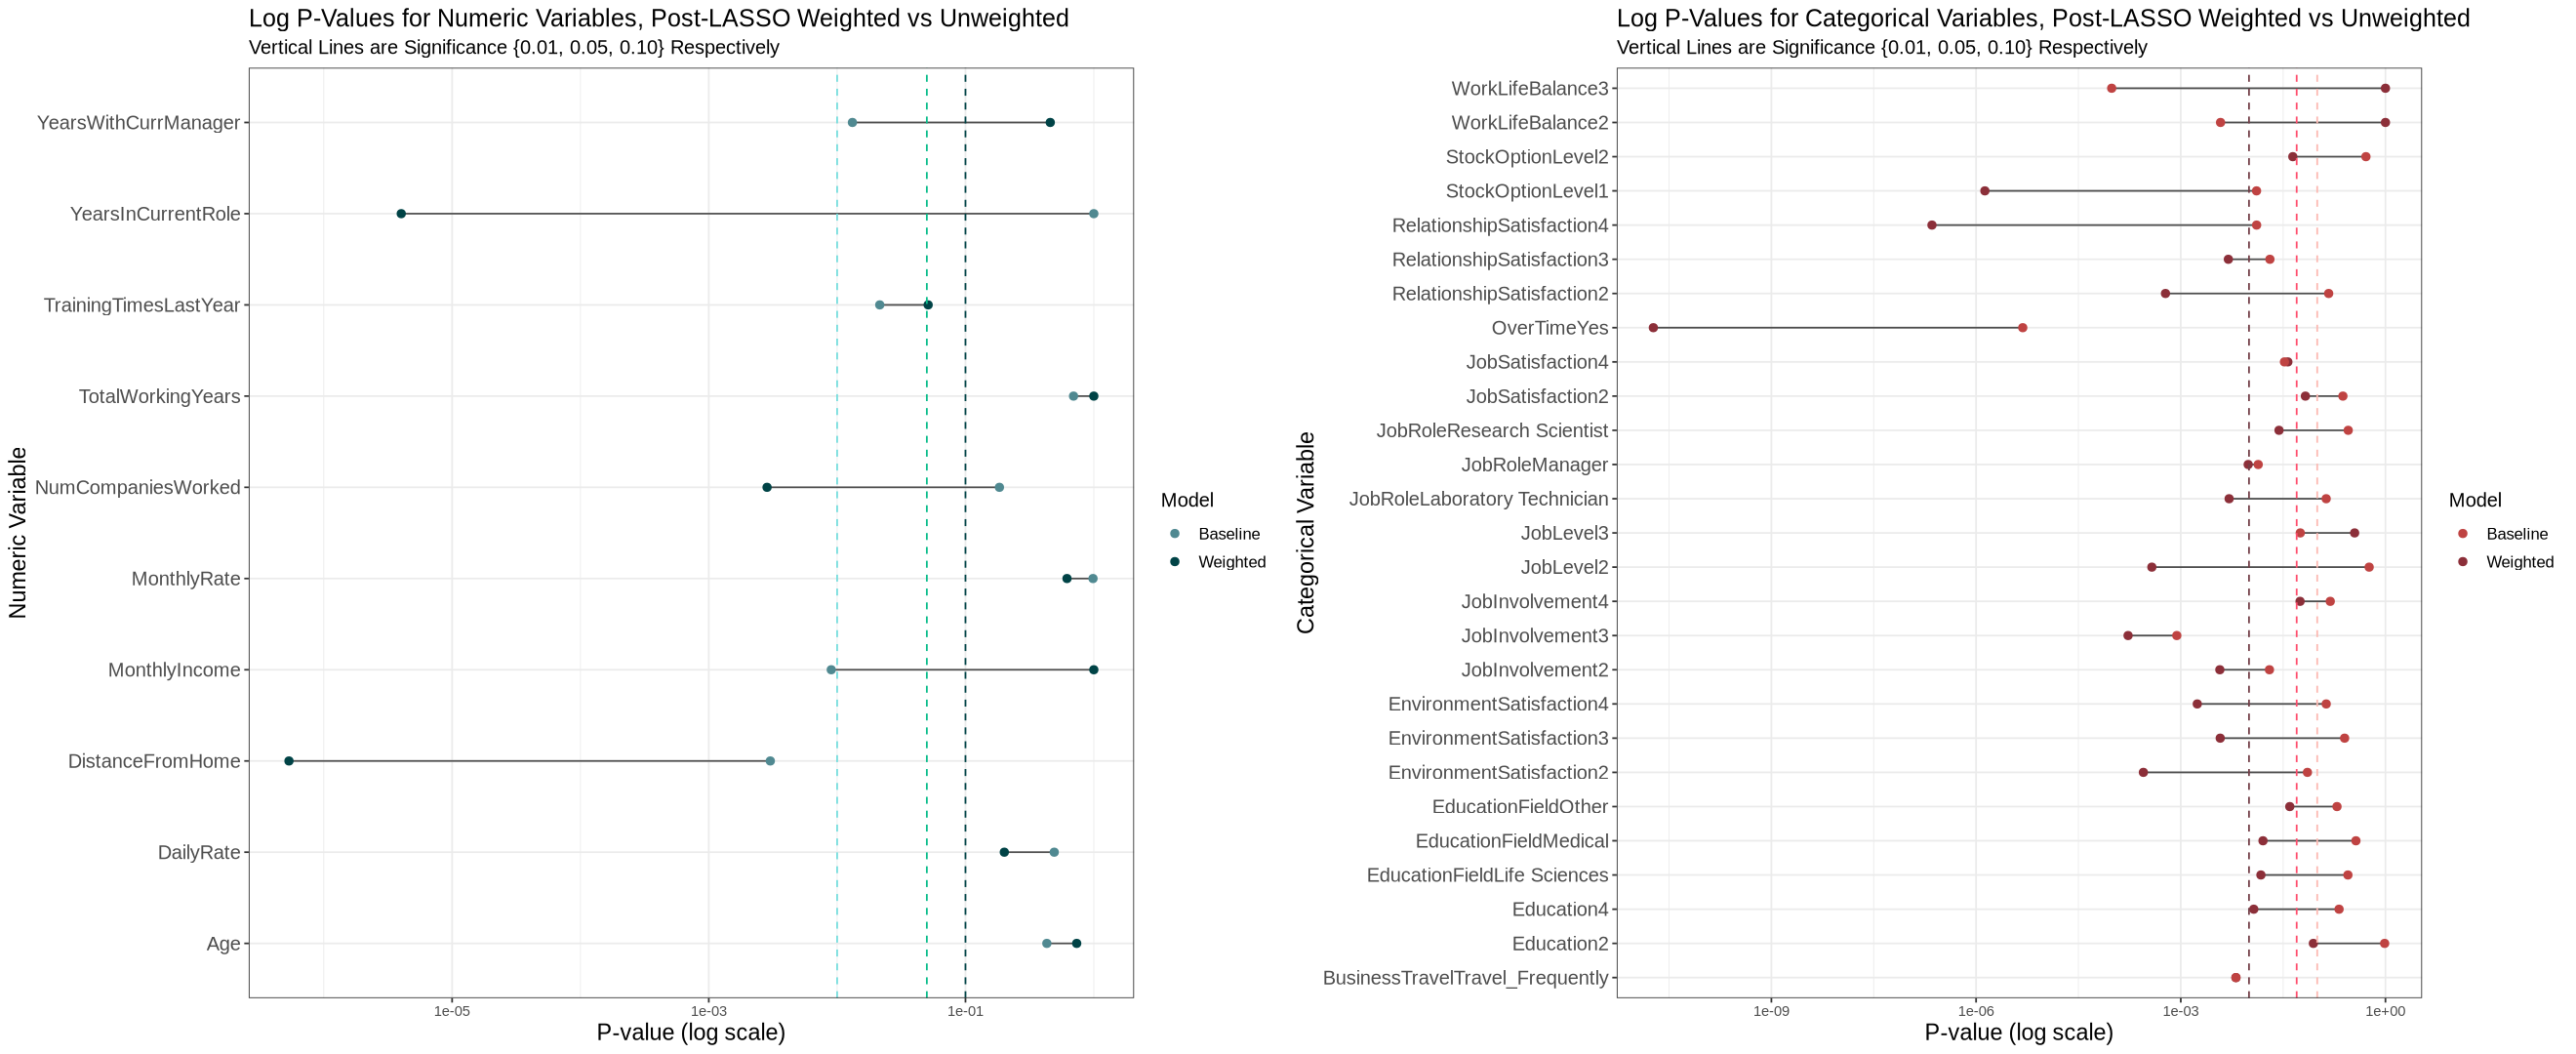

In [15]:
# Main developer: Caden
# ------------------- #
# -- Category Coef -- #
# ------------------- #
# for the second plot, we do the p-values of categorical columns
plotDF_C <- plotDF[!plotDF$variable %in% numeric_cols, ]
# however there are many more than numeric
# so we select only those with at least one significant at 0.10
plotDF_C <- plotDF_C[plotDF_C$Weighted < 0.10 | plotDF_C$Baseline < 0.10, ]
# we pivot the data to prepare it for plotting
plotDF_longC <- plotDF_C %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pC <- ggplot(plotDF_longC, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Categorical Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#8c2f39",
    "Baseline" = "#bf4342"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#723d46") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#ff4d6d") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#fcb9b2") +
  labs(title = "Log P-Values for Categorical Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 
grid.arrange(pN, pC, ncol = 2)